## example notebook that pulls NEXRAD data from AWS, along with gauge data (in this example from CoAgMET), and plots them together over a specified timeframe and location

### Uses Py-ART and the nexradaws package. Builds off of this example: https://nexradaws.readthedocs.io/en/latest/Tutorial.html 

### imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

import pyart
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

import nexradaws
from datetime import datetime, timedelta
import tempfile
import pytz

templocation = tempfile.mkdtemp()



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/pyart/io/nexrad_level3.py:72: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from xdrlib import Unpacker
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/botocore/utils.py:15: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


### set up some specifications for the plots you want to make

In [2]:
## which radar, and over what time period?
radar_id = 'KGLD'
start = datetime(2021,8,19,21,0)
end = datetime(2021,8,20,7,30)

## what lat/lon area to plot?
min_lon = -103.8
max_lon = -100.8
min_lat = 39.5
max_lat = 41.6


### now get NEXRAD data using this method: https://nexradaws.readthedocs.io/en/latest/Tutorial.html

In [3]:
conn = nexradaws.NexradAwsInterface()

scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))
print(scans[0:4])

## download these files
results = conn.download(scans, templocation)

There are 142 scans available between 2021-08-19 21:00:00 and 2021-08-20 07:30:00

[<AwsNexradFile object - 2021/08/19/KGLD/KGLD20210819_210406_V06>, <AwsNexradFile object - 2021/08/19/KGLD/KGLD20210819_210931_V06>, <AwsNexradFile object - 2021/08/19/KGLD/KGLD20210819_211456_V06>, <AwsNexradFile object - 2021/08/19/KGLD/KGLD20210819_212012_V06>]
Downloaded KGLD20210819_211456_V06
Downloaded KGLD20210819_212537_V06
Downloaded KGLD20210819_213102_V06
Downloaded KGLD20210819_210406_V06
Downloaded KGLD20210819_210931_V06
Downloaded KGLD20210819_212012_V06
Downloaded KGLD20210819_214152_V06
Downloaded KGLD20210819_213627_V06
Downloaded KGLD20210819_214718_V06
Downloaded KGLD20210819_215808_V06_MDM
Downloaded KGLD20210819_215243_V06
Downloaded KGLD20210819_215808_V06
Downloaded KGLD20210819_220332_V06
Downloaded KGLD20210819_222504_V06
Downloaded KGLD20210819_221413_V06
Downloaded KGLD20210819_220857_V06
Downloaded KGLD20210819_221939_V06
Downloaded KGLD20210819_223555_V06
Downloaded KGLD202

### print out the date/time of each scan

In [4]:
for scan in results.iter_success():
    #print ("{} volume scan time {}".format(scan.radar_id,scan.scan_time))
    print(scan.filename[4:17])

20210819_2104
20210819_2109
20210819_2114
20210819_2120
20210819_2125
20210819_2131
20210819_2136
20210819_2141
20210819_2147
20210819_2152
20210819_2158
20210819_2158
20210819_2203
20210819_2208
20210819_2214
20210819_2219
20210819_2225
20210819_2230
20210819_2235
20210819_2241
20210819_2246
20210819_2251
20210819_2257
20210819_2257
20210819_2302
20210819_2307
20210819_2312
20210819_2318
20210819_2323
20210819_2329
20210819_2334
20210819_2339
20210819_2344
20210819_2350
20210819_2355
20210819_2355
20210820_0000
20210820_0006
20210820_0011
20210820_0017
20210820_0022
20210820_0027
20210820_0033
20210820_0038
20210820_0043
20210820_0049
20210820_0054
20210820_0100
20210820_0100
20210820_0105
20210820_0113
20210820_0118
20210820_0123
20210820_0127
20210820_0132
20210820_0137
20210820_0142
20210820_0147
20210820_0151
20210820_0156
20210820_0156
20210820_0201
20210820_0206
20210820_0211
20210820_0216
20210820_0221
20210820_0226
20210820_0231
20210820_0236
20210820_0241
20210820_0246
202108

### Now read in whatever gauge data you want to plot. This will work best if you have access to 5 or 10-minute data from a mesonet, because that will roughly correspond to the time of a radar scan. (This won't look very good if you only have hourly data.) 

### In this example, we'll pull 5-minute data from the CoAgMET API, for the HYK02 (Holyoke) station
### CoAgMET API details at: https://coagmet.colostate.edu/data/url-builder

### This will be the step that the user will need to modify if pulling from different data sources. The end result needs to be a pandas dataframe with a datetime index and precip in one of the columns

In [5]:
url="https://coagmet.colostate.edu/data/5min.csv?header=yes&from=2021-08-19&to=2021-08-21&tz=utc&fields=precip&stations=hyk02"
gauge = pd.read_csv(url, skiprows=[1])

### set a pandas datetime from the datetime in the dataset
gauge['datetime'] = pd.to_datetime(gauge['Date and Time']).dt.tz_localize("UTC")
gauge.set_index('datetime',inplace=True)

## print out the data to make sure it looks ok
gauge


,Station,Date and Time,Precip
datetime,,,
2021-08-19 00:00:00+00:00,hyk02,08/19/2021 00:00,0.0
2021-08-19 00:05:00+00:00,hyk02,08/19/2021 00:05,0.0
2021-08-19 00:10:00+00:00,hyk02,08/19/2021 00:10,0.0
2021-08-19 00:15:00+00:00,hyk02,08/19/2021 00:15,0.0
2021-08-19 00:20:00+00:00,hyk02,08/19/2021 00:20,0.0
...,...,...,...
2021-08-21 23:35:00+00:00,hyk02,08/21/2021 23:35,0.0
2021-08-21 23:40:00+00:00,hyk02,08/21/2021 23:40,0.0
2021-08-21 23:45:00+00:00,hyk02,08/21/2021 23:45,0.0


### now go on to make the maps of reflectivity and the gauge data inset!

### this plotting mainly follows from this example: https://arm-doe.github.io/pyart/source/auto_examples/plotting/plot_ppi_with_rings.html

1
working on KGLD20210819_210406_V06


/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


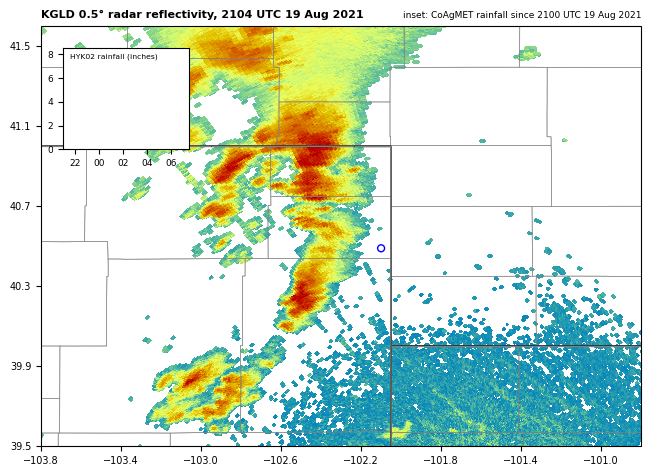

2
working on KGLD20210819_210931_V06


/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


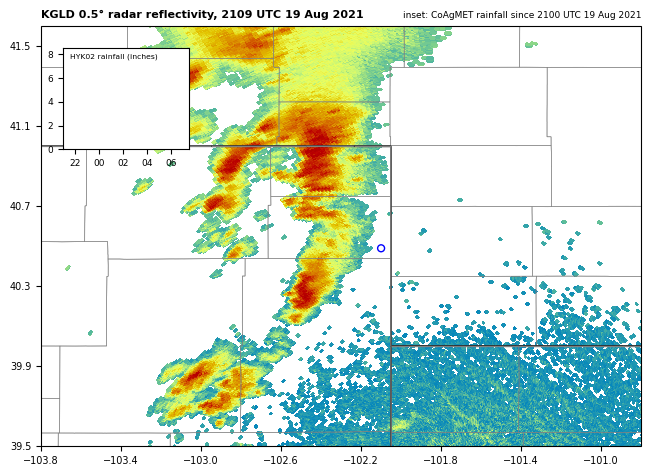

3
working on KGLD20210819_211456_V06



KeyboardInterrupt



In [8]:
## loop over the scans that were pulled in from AWS
for i,scan in enumerate(results.iter_success(),start=1):

    ## skip the files ending in "MDM"
    if scan.filename[-3:] != "MDM":
        
        print(str(i))
        print("working on "+scan.filename)
        
        this_time = pd.to_datetime(scan.filename[4:17], format="%Y%m%d_%H%M").tz_localize("UTC")      
    
        radar = scan.open_pyart()

        fig = plt.figure(figsize=[15, 7])

        map_panel_axes = [0.05, 0.05, .4, .80]
        x_cut_panel_axes = [0.55, 0.10, .4, .25]
        y_cut_panel_axes = [0.55, 0.50, .4, .25]

        projection = ccrs.PlateCarree()

        ## apply gatefilter (see here: https://arm-doe.github.io/pyart/notebooks/masking_data_with_gatefilters.html)
        #gatefilter = pyart.correct.moment_based_gate_filter(radar)
        gatefilter = pyart.filters.GateFilter(radar)

        # Lets remove reflectivity values below a threshold.
        gatefilter.exclude_below('reflectivity', -2.5)

        display = pyart.graph.RadarMapDisplay(radar)
       
        ## set up the figure
        ax1 = fig.add_axes(map_panel_axes, projection=projection)
        
        # Add some various map elements to the plot to make it recognizable.
        ax1.add_feature(USCOUNTIES.with_scale('500k'), edgecolor="gray", linewidth=0.4)
        #ax1.coastlines('50m', edgecolor='black', linewidth=0.75)
        ax1.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.0)
        
        ### make the plot! we'll use the Homeyer rainbow colortable
        cf = display.plot_ppi_map('reflectivity', 0, vmin=-7.5, vmax=65,
                                  ax=ax1,
                          min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                          projection=projection, resolution='10m',
                          gatefilter=gatefilter,
                          cmap='pyart_HomeyerRainbow', 
                          colorbar_flag=False, ## don't use the default colorbar
                          title_flag=False, ## don't use the default title
                          lat_lines=[0,0], lon_lines=[0,0]) ## turns off lat/lon grid lines
               
        ## do horizontal colorbar
        ## one issue with colorbars in pyart is they aren't very customizable, so leaving it out here
        #display.plot_colorbar(cf,orient='horizontal', shrink=0.75, pad=0.05, aspect=50)
                        
        ## add a better title
        ## get sweep angle:
        elev = radar.fixed_angle['data'][0].round(1)
        ax1.set_title(radar_id+" "+str(elev)+u"\N{DEGREE SIGN} radar reflectivity, "+this_time.strftime("%H%M UTC %d %b %Y"), 
                     loc='left', fontweight='semibold', fontsize=8)
        ax1.set_title("inset: CoAgMET rainfall since "+pd.Timestamp(start).strftime("%H%M UTC %d %b %Y"),
                     loc='right', fontsize=6.5)
        
        ### tick marks
        ax1.set_xticks(np.arange(min_lon, max_lon, .4), crs=ccrs.PlateCarree())
        ax1.set_yticks(np.arange(min_lat, max_lat, .4), crs=ccrs.PlateCarree())    
        ax1.tick_params(axis='both', which='major', labelsize=7)
        
        ## add marker points for the gauge(s)
        lons = [-102.1]
        lats = [40.49]
        stn_names = ["Holyoke"]  ## list of station names
        edgecolors=['blue']  ## list of colors for the circles
                
        ## plot the circles
        ax1.scatter(lons, lats, s=25, facecolors='none', 
                    edgecolors=edgecolors, linewidths=1)

        
        ## set up inset plot in a corner
        ## width and height can be customized; loc 1 is upper right; 2 upper left; 3 lower left; 4 lower right
        axinset = inset_axes(ax1, width="21%", height="24%", loc=2, borderpad=1.6)
        ## plot the precip from the defined radar start time, to the time of the current image
        axinset.plot(gauge.Precip[pd.to_datetime(start).strftime("%Y-%m-%d %H:%M"):this_time.strftime("%Y-%m-%d %H:%M")].cumsum(), 
                     color='blue', label='Holyoke', linewidth=0.8)  
        
        ## Set time format and the interval of ticks (in this example, every 2 hrs)
        xformatter = mdates.DateFormatter('%H')
        xlocator = mdates.HourLocator(interval = 2)
        axinset.xaxis.set_major_locator(xlocator)
        axinset.xaxis.set_major_formatter(xformatter)
        axinset.tick_params(axis='both', which='major', labelsize=6.5)
        
        ## match the axis limit to the start and end time (so they're the same on all plots)
        axinset.set_xlim(pd.Timestamp(start).tz_localize("UTC"),
                         pd.Timestamp(end).tz_localize("UTC"))
        axinset.set_ylim(0,8.5)
        
        ## add a title if desired
        axinset.text(.05,.9,'HYK02 rainfall (inches)',
                     transform=axinset.transAxes,fontsize=5.5)
    
        ### save the figure
        plt.savefig(scan.radar_id+"_"+scan.filename[4:17]+"_dz.png",bbox_inches='tight',dpi=300,
                   facecolor='white', transparent=False)
        plt.show()
        plt.close('all')
